# Theory Beakdown
This breaks down each contribution to the theoretical scaling factor.

In [29]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms,mse_mod_anom_change_ft_expansion, mse_mod_change_surf_expansion, \
    get_scaling_factor_theory, get_temp_adiabat
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [30]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE


use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [31]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

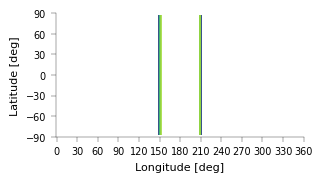

In [32]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [33]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_mean = np.zeros((n_kappa, n_pressure, n_lat))
sphum_mean_from_sphum = np.zeros((n_kappa, n_lat))      # actual mean sphum
sphum_mean_from_r = np.zeros((n_kappa, n_lat))          # compute mean sphum from mean rh
r_mean_from_sphum = np.zeros((n_kappa, n_lat))          # compute mean rh from mean sphu
r_mean_from_r = np.zeros((n_kappa, n_lat))              # actual mean rh
z_mean = np.zeros((n_kappa, n_pressure, n_lat))
mse_mean = np.zeros((n_kappa, n_lat))
mse_ft_sat_mean = np.zeros((n_kappa, n_lat))
epsilon_mean = np.zeros((n_kappa, n_lat))

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_mean[j] = ds_use.temp.mean(dim='lon_time')
        sphum_mean_from_sphum[j] = ds_use.sphum[0].mean(dim='lon_time')
        z_mean[j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_mean_from_r[j] = rh_use.mean(dim='lon_time')
        mse_use = [moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]), 
                   moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), ds_use.height[ind_ft])]
        mse_mean[j] = mse_use[0].mean(dim='lon_time')
        mse_ft_sat_mean[j] = mse_use[1].mean(dim='lon_time')
        epsilon_use = mse_use[0] - mse_use[1]
        epsilon_mean[j] = epsilon_use.mean(dim='lon_time')
        pbar.update(1)
sphum_mean_from_r = r_mean_from_r * sphum_sat(temp_mean[:, ind_surf], p_surface) 
r_mean_from_sphum = sphum_mean_from_sphum / sphum_sat(temp_mean[:, ind_surf], p_surface) 

100%|██████████| 2/2 [00:22<00:00, 11.34s/it]


In [34]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
# relative humidity as function of temp quantile not temp quantile
sphum_quant3_from_sphum = np.zeros((n_kappa, n_lat, n_quant))
sphum_quant3_from_r = np.zeros((n_kappa, n_lat, n_quant))
r_quant3_from_sphum = np.zeros((n_kappa, n_lat, n_quant))
r_quant3_from_r = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting
mse_quant3 = np.zeros((n_kappa, n_lat, n_quant))
mse_ft_sat_quant3 = np.zeros((n_kappa, n_lat, n_quant))
epsilon_quant3 = np.zeros((n_kappa, n_lat, n_quant))

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        mse_use = [moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]), 
                   moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), ds_use.height[ind_ft])]
        epsilon_use = mse_use[0] - mse_use[1]
        is_convecting = np.logical_and(ds_use.klzbs<klzb_thresh, ds_use.convflag > convflag_thresh)
        for k in range(n_lat):
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                # Make sure to compute temp_quant at FT level using near-surface quantiles
                temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                sphum_quant3_from_sphum[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                r_quant3_from_r[j, k, q] = rh_use[k, use_ind].mean(dim='lon_time')
                mse_quant3[j, k, q] = mse_use[0][k, use_ind].mean(dim='lon_time')
                mse_ft_sat_quant3[j, k, q] = mse_use[1][k, use_ind].mean(dim='lon_time')
                epsilon_quant3[j, k, q] = epsilon_use[k, use_ind].mean(dim='lon_time')
                convflag_quant3[j, k, q] = ds_use.convflag[k, use_ind].mean(dim='lon_time')
                klzbs_quant3[j, k, q] = ds_use.klzbs[k, use_ind].mean(dim='lon_time')
                convfract_quant3[j, k, q] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)
sphum_quant3_from_r = sphum_sat(temp_quant3[:, ind_surf], p_surface) * r_quant3_from_r # compute specific humidity from relative humidity
r_quant3_from_sphum = sphum_quant3_from_sphum / sphum_sat(temp_quant3[:, ind_surf], p_surface)
temp_anom = temp_quant3 - temp_mean[:, :, :, np.newaxis]
epsilon_anom = epsilon_quant3 - epsilon_mean[:, :, np.newaxis]

100%|██████████| 2772/2772 [00:09<00:00, 294.78it/s]


## Humidity Calculation
Specific and relative humidity are related through $q_s = r_s q^*(T_s, p_s)$. When taking the mean, due to non-linear $q_s$ function, there is a difference between the value of $q_s$ when it is computed from the average of $r_s$ over all days ($r$ method) to when it is taken as the average of specific humidity on each day ($q$ method).

Below I investigate the effect of this. The difference is only apparent in the mean value, not as a function of quantile.

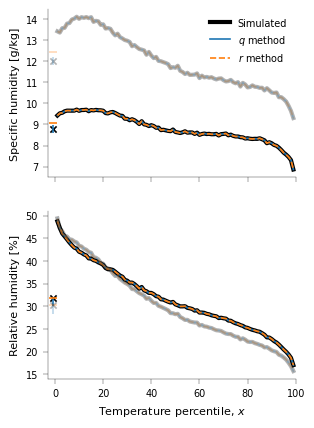

In [35]:
save_humidity_calc_fig = False

fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
opacity_kappa = [1, 0.3]
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(sphum_quant3_from_sphum[i], axis=0, weights=lat_weights)*1000, color='k', 
               alpha=opacity_kappa[i], lw=3, label='Simulated' if i==0 else None)
    ax[0].plot(quant_plot, np.average(sphum_quant3_from_sphum[i], axis=0, weights=lat_weights)*1000, color=default_colors[0],
               alpha=opacity_kappa[i], label='$q$ method' if i==0 else None)
    ax[0].plot(quant_plot, np.average(sphum_quant3_from_r[i], axis=0, weights=lat_weights)*1000, 
               color=default_colors[1], linestyle='--', alpha=opacity_kappa[i], label='$r$ method' if i==0 else None)
    
    ax[0].scatter(-1, np.average(sphum_mean_from_sphum[i], axis=0, weights=lat_weights)*1000, color='k', marker='x', s=20, alpha=opacity_kappa[i])
    ax[0].scatter(-1, np.average(sphum_mean_from_sphum[i], axis=0, weights=lat_weights)*1000, color=default_colors[0], marker='|', s=30,
                  alpha=opacity_kappa[i])
    ax[0].scatter(-1, np.average(sphum_mean_from_r[i], axis=0, weights=lat_weights)*1000, color=default_colors[1], marker='_', s=30, 
                  alpha=opacity_kappa[i])
    
    ax[1].plot(quant_plot, np.average(r_quant3_from_r[i], axis=0, weights=lat_weights)*100, color='k', alpha=opacity_kappa[i], lw=3)
    ax[1].plot(quant_plot, np.average(r_quant3_from_sphum[i], axis=0, weights=lat_weights)*100, color=default_colors[0], alpha=opacity_kappa[i])
    ax[1].plot(quant_plot, np.average(r_quant3_from_r[i], axis=0, weights=lat_weights)*100, 
               color=default_colors[1], alpha=opacity_kappa[i], linestyle='--')
    
    ax[1].scatter(-1, np.average(r_mean_from_r[i], axis=0, weights=lat_weights)*100, color='k', marker='x', s=20, alpha=opacity_kappa[i])
    ax[1].scatter(-1, np.average(r_mean_from_sphum[i], axis=0, weights=lat_weights)*100, color=default_colors[0], marker='|', s=30, 
                  alpha=opacity_kappa[i])
    ax[1].scatter(-1, np.average(r_mean_from_r[i], axis=0, weights=lat_weights)*100, color=default_colors[1], marker='_', s=30, alpha=opacity_kappa[i])

ax[0].legend()
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(-3, 100)
ax[0].set_ylabel('Specific humidity [g/kg]')
ax[1].set_ylabel('Relative humidity [%]')

if save_fig or save_humidity_calc_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/humidity_calc_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Effect on MSE and $\epsilon$
At the surface, MSE is defined as $h_s = c_p T_s + L_v q_s + gz_s$. Thus it is senstive to the $q_s$ used:
* $q$ method: This is equivalent to taking $\overline{q_s}$ to be the average specific humidity for all days.
* $r$ method: Here, I compute $\overline{q_s} = \overline{r_s} q^*(\overline{T_s}, p_s)$. Where $\overline{r_s}$ is the relative humidity averaged over all days.

The $q$ method matches the simulated mean value exactly. However, we see that the $r$ method over-estimates $\overline{h}$, but it has the advantage that $\overline{r_s}$ must be less than 1 in this case (see above).

For our simulations, I think it makes sense to use the $q$ method as we always have $r<1$ anyway from tropical summer, but the $\epsilon$ effect is apparent.

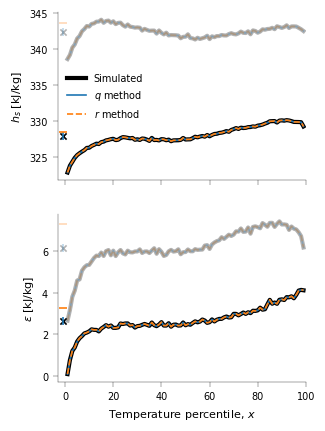

In [36]:
mse_mean_from_sphum = moist_static_energy(temp_mean[:, ind_surf], sphum_mean_from_sphum, z_mean[:, ind_surf])
mse_quant3_from_sphum = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3_from_r, z_quant3[:, ind_surf])
mse_mean_from_r = moist_static_energy(temp_mean[:, ind_surf], sphum_mean_from_r, z_mean[:, ind_surf])
mse_quant3_from_r = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3_from_r, z_quant3[:, ind_surf])

epsilon_mean_from_sphum = mse_mean_from_sphum - mse_ft_sat_mean
epsilon_quant3_from_sphum = mse_quant3_from_sphum - mse_ft_sat_quant3
epsilon_mean_from_r = mse_mean_from_r - mse_ft_sat_mean
epsilon_quant3_from_r = mse_quant3_from_r - mse_ft_sat_quant3

save_mse_calc_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(mse_quant3[i], axis=0, weights=lat_weights), color='k', 
               alpha=opacity_kappa[i], lw=3, label='Simulated' if i==0 else None)
    ax[0].plot(quant_plot, np.average(mse_quant3_from_sphum[i], axis=0, weights=lat_weights), color=default_colors[0],
               alpha=opacity_kappa[i], label='$q$ method' if i==0 else None)
    ax[0].plot(quant_plot, np.average(mse_quant3_from_r[i], axis=0, weights=lat_weights), 
               color=default_colors[1], linestyle='--', alpha=opacity_kappa[i], label='$r$ method' if i==0 else None)
    
    ax[0].scatter(-1, np.average(mse_mean[i], axis=0, weights=lat_weights), color='k', marker='x', s=20, alpha=opacity_kappa[i])
    ax[0].scatter(-1, np.average(mse_mean_from_sphum[i], axis=0, weights=lat_weights), color=default_colors[0], marker='|', s=30,
                  alpha=opacity_kappa[i])
    ax[0].scatter(-1, np.average(mse_mean_from_r[i], axis=0, weights=lat_weights), color=default_colors[1], marker='_', s=30, 
                  alpha=opacity_kappa[i])
    
    ax[1].plot(quant_plot, np.average(epsilon_quant3[i], axis=0, weights=lat_weights), color='k', alpha=opacity_kappa[i], lw=3)
    ax[1].plot(quant_plot, np.average(epsilon_quant3_from_sphum[i], axis=0, weights=lat_weights), color=default_colors[0], alpha=opacity_kappa[i])
    ax[1].plot(quant_plot, np.average(epsilon_quant3_from_r[i], axis=0, weights=lat_weights), 
               color=default_colors[1], linestyle='--', alpha=opacity_kappa[i])
    
    ax[1].scatter(-1, np.average(epsilon_mean[i], axis=0, weights=lat_weights), color='k', marker='x', s=20, alpha=opacity_kappa[i])
    ax[1].scatter(-1, np.average(epsilon_mean_from_sphum[i], axis=0, weights=lat_weights), color=default_colors[0], marker='|', s=30, 
                  alpha=opacity_kappa[i])
    ax[1].scatter(-1, np.average(epsilon_mean_from_r[i], axis=0, weights=lat_weights), color=default_colors[1], marker='_', s=30, alpha=opacity_kappa[i])
    
ax[0].legend()
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(-3, 100)
ax[0].set_ylabel('$h_s$ [kJ/kg]')
ax[1].set_ylabel('$\epsilon$ [kJ/kg]')

if save_fig or save_mse_calc_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_calc_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [37]:
# Choose a humidity method - only really affects mean value
# Think probably makes sense to use 'sphum' when considering tropical summer
humidity_calc_method = 'sphum'
if humidity_calc_method == 'sphum':
    sphum_mean = sphum_mean_from_sphum
    sphum_quant3 = sphum_quant3_from_sphum
    r_mean = r_mean_from_sphum
    r_quant3 = r_quant3_from_sphum
elif humidity_calc_method == 'r':
    sphum_mean = sphum_mean_from_r
    sphum_quant3 = sphum_quant3_from_r
    r_mean = r_mean_from_r
    r_quant3 = r_quant3_from_r

## Assumptions of Theory
The theory with just $\delta \overline{T_s}$ term makes three approximations about CAPE and relative humidity in the mean climate:
* Negligible CAPE on mean day in current climate: $\left|\frac{\overline{\epsilon}}{\beta_{A1}\overline{T_A}}\right|<<1$
* Small change in mean CAPE with warming: $\left|\frac{\delta \overline{\epsilon}}{\overline{\beta_{s1}} \delta \overline{T_s}}\right|<<1$
* Small change in mean relative humidity with warming: $\left|\frac{L_v \overline{q_s^*}}{\overline{\beta_{s1}}}\frac{\delta \overline{r_s}}{\delta \overline{T_s}}\right| << 1$

The plots below show these fractions, to test how well they are satisfied as a function of latitude. The solid (dotted) lines are for the northern (southern) hemisphere.

In [38]:
temp_adiabat_mean = np.zeros((n_kappa, n_lat))
for j in range(n_lat):
    for i in range(n_kappa):
        temp_adiabat_mean[i, j] = get_temp_adiabat(temp_mean[i, ind_surf, j], sphum_mean[i, j], p_surface, pressure_ft_actual)
_, q_sat_s, _, beta_s1, beta_s2, _ = get_theory_prefactor_terms(temp_mean[0, ind_surf], p_surface, pressure_ft_actual, sphum_mean[0])
_, _, _, beta_a1, _, _ = get_theory_prefactor_terms(temp_adiabat_mean[0], p_surface, pressure_ft_actual)

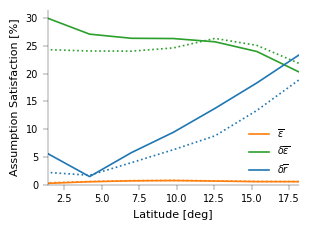

In [39]:
temp_s_mean_change = temp_mean[1, ind_surf] - temp_mean[0, ind_surf]
assumption_epsilon_mean = (epsilon_mean[0]*1000/(beta_a1 * temp_adiabat_mean[0]))*100
assumption_epsilon_mean_change = (epsilon_mean[1]-epsilon_mean[0]) * 1000 / (beta_s1 * temp_s_mean_change) * 100
assumption_r_mean_change = L_v * q_sat_s/beta_s1 * (r_mean[1]-r_mean[0]) / temp_s_mean_change * 100
colors_temp_ft = {'temp_s': default_colors[3], 'r': default_colors[0], 'epsilon': default_colors[2]}

lat = ds[0].lat[lat_use_ind].to_numpy()
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(lat[lat>0], np.abs(assumption_epsilon_mean[lat>0]), color=default_colors[1], label='$\overline{\epsilon}$')
ax.plot(-lat[lat<0], np.abs(assumption_epsilon_mean[lat<0]), color=default_colors[1], linestyle=':')
ax.plot(lat[lat>0], np.abs(assumption_epsilon_mean_change[lat>0]), color=colors_temp_ft['epsilon'], label='$\delta \overline{\epsilon}$')
ax.plot(-lat[lat<0], np.abs(assumption_epsilon_mean_change[lat<0]), color=colors_temp_ft['epsilon'], linestyle=':')
ax.plot(lat[lat>0], np.abs(assumption_r_mean_change[lat>0]), color=colors_temp_ft['r'], label='$\delta \overline{r}$')
ax.plot(-lat[lat<0], np.abs(assumption_r_mean_change[lat<0]), color=colors_temp_ft['r'], linestyle=':')
ax.set_xlim(lat[lat>0][0], lat[lat>0][-1])
ax.set_xlabel('Latitude [deg]')
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('Assumption Satisfaction [%]')
ax.legend()
plt.tight_layout()

### $\delta \overline{T_{FT}}$ Breakdown
The latter two approximations are really saying that the approximation $\delta \overline{T_{FT}} \approx \delta \overline{h^{\dagger}}/\beta_{FT1}$ is dominated by changes in $\delta \overline{T_s}$ and so can be simplified to $\delta \overline{T_{FT}} \approx \frac{\overline{\beta_{s1}}}{\beta_{FT1}}\delta \overline{T_s}$.

Without making the two approximations though, we would have: $\delta \overline{T_{FT}} \approx \frac{\overline{\beta_{s1}}}{\beta_{FT1}}\delta \overline{T_s}\left[1 + \frac{L_v \overline{q_s^*}}{\overline{\beta_{s1}}}\frac{\delta \overline{r_s}}{\delta \overline{T_s}} - \frac{\delta \overline{\epsilon}}{\overline{\beta_{s1}} \delta \overline{T_s}}\right]$.

Below I break down the contribution to $\delta \overline{T_{FT}}$. It seems that the $\delta \overline{r_s}$ and $\delta \overline{\epsilon}$ terms oppose each other so making both assumptions is better than making one, and the red line matches the black line well.

Over land, it seems that changes in mean CAPE and mean relative humidity are important.

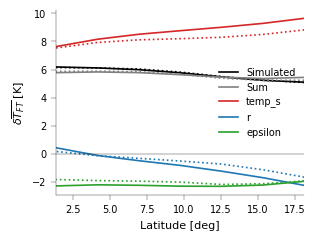

In [40]:
# Choose whether to use beta_ft1 (no assumption on mean CAPE) or beta_a1 (making orange assumption above)
_, _, _, beta_ft1, _, _ = get_theory_prefactor_terms(temp_mean[0, ind_ft], p_surface, pressure_ft_actual)

temp_ft_mean_change_breakdown = {'temp_s': beta_s1/beta_ft1 * temp_s_mean_change}
temp_ft_mean_change_breakdown['r'] = temp_ft_mean_change_breakdown['temp_s'] * assumption_r_mean_change/100
temp_ft_mean_change_breakdown['epsilon'] = -temp_ft_mean_change_breakdown['temp_s'] * assumption_epsilon_mean_change/100
temp_ft_mean_change_breakdown_sum = sum(temp_ft_mean_change_breakdown[key] for key in temp_ft_mean_change_breakdown)

save_temp_ft_mean_change_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(lat[lat>0], (temp_mean[1, ind_ft] - temp_mean[0, ind_ft])[lat>0], color='k', label='Simulated')
ax.plot(-lat[lat<0], (temp_mean[1, ind_ft] - temp_mean[0, ind_ft])[lat<0], color='k', linestyle=':')
ax.plot(lat[lat>0], temp_ft_mean_change_breakdown_sum[lat>0], color='grey', label='Sum')
ax.plot(-lat[lat<0], temp_ft_mean_change_breakdown_sum[lat<0], color='grey', linestyle=':')
for key in temp_ft_mean_change_breakdown:
    ax.plot(lat[lat>0], temp_ft_mean_change_breakdown[key][lat>0], color=colors_temp_ft[key], label=key)
    ax.plot(-lat[lat<0], temp_ft_mean_change_breakdown[key][lat<0], color=colors_temp_ft[key], linestyle=':')
ax.set_xlim(lat[lat>0][0], lat[lat>0][-1])
ax.set_xlabel('Latitude [deg]')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$\delta \overline{T_{FT}}$ [K]')
ax.legend()

if save_fig or save_temp_ft_mean_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_ft_mean_change_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Theory
First I just plot the theoretical scaling factor and compare it to the simulated.

In [150]:
sf_simulated = (temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf]) / temp_s_mean_change[:, np.newaxis]
sf_theory = {'linear': np.zeros((n_lat, n_quant)), 'non_linear': np.zeros((n_lat, n_quant)), 'no_epsilon': np.ones((n_lat, n_quant))}
keys_sf_breakdown = {var+'_mean_change': ['t0', 't0_r0', 'r0', 'e0'] for var in ['t', 'r', 'e']}
keys_sf_breakdown['anomaly_change'] = ['r', 't0_r', 'ft', 'e']
sf_theory_breakdown = {key1: {key2: np.zeros((n_lat, n_quant)) for key2 in keys_sf_breakdown[key1]} for key1 in keys_sf_breakdown}
for i in range(n_lat):
    for key in ['non_linear', 'linear']:
        sf_theory[key][i], _, _, info_cont, _ = get_scaling_factor_theory(temp_mean[:, ind_surf, i], temp_quant3[:, ind_surf, i], sphum_mean[:, i],
                                                                          sphum_quant3[:, i], p_surface, pressure_ft_actual, temp_mean[:, ind_ft, i], 
                                                                          temp_quant3[:, ind_ft, i], z_mean[:, ind_ft, i], z_quant3[:, ind_ft, i],
                                                                          non_linear=key=='non_linear', use_temp_adiabat=True, strict_conv_eqb=False, 
                                                                          simple=False)
        if key == 'linear':
            # Only record breakdown for linear case as easier to interpret
            for key1 in keys_sf_breakdown:
                for key2 in keys_sf_breakdown[key1]:
                    sf_theory_breakdown[key1][key2][i] = info_cont[key1][key2]
                    if ('e_mean' in key1) or ('e' in key2):
                        continue
                    sf_theory['no_epsilon'][i] = sf_theory['no_epsilon'][i] + info_cont[key1][key2]

(0.0, 100.0)

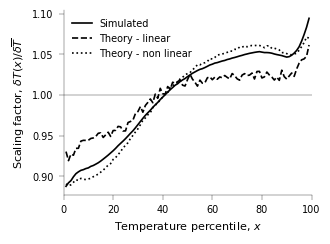

In [151]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k',
           label='Simulated')
ax.plot(quant_plot, np.average(sf_theory['linear'], weights=lat_weights, axis=0), color='k', linestyle='--', label='Theory - linear')
ax.plot(quant_plot, np.average(sf_theory['non_linear'], weights=lat_weights, axis=0), color='k', linestyle=':', label='Theory - non linear')
ax.legend()
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)

### Breakdown into 4 change contributions
The theory can be split into 4 change ($\delta$) terms: 
* ${\delta \overline{T_s}$
* $\delta \overline{r_s}$
* $\delta \overline{\epsilon_s}$
* $\delta \Delta \chi(x)$ terms for $\chi = r, T_{FT}, \epsilon$

Here I plot the contribution of each of these (assuming the linear theory.

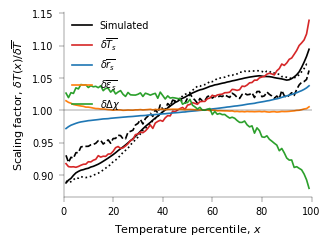

In [152]:
colors_breakdown = {'t_mean_change': default_colors[3], 'r_mean_change': default_colors[0], 'e_mean_change': default_colors[1], 
                    'anomaly_change': default_colors[2]}
labels_breakdown1 = {'t_mean_change': '$\delta \overline{T_s}$', 'r_mean_change': '$\delta \overline{r_s}$', 
                     'e_mean_change': '$\delta \overline{\epsilon_s}$', 'anomaly_change': '$\delta \Delta \chi$'}

save_breakdown_change_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k',
           label='Simulated')
ax.plot(quant_plot, np.average(sf_theory['linear'], weights=lat_weights, axis=0), color='k', linestyle='--')
ax.plot(quant_plot, np.average(sf_theory['non_linear'], weights=lat_weights, axis=0), color='k', linestyle=':')
for key1 in keys_sf_breakdown:
    ax.plot(quant_plot, 1+np.average(sum([sf_theory_breakdown[key1][key2] for key2 in keys_sf_breakdown[key1]]), weights=lat_weights, axis=0),
            color=colors_breakdown[key1], label=labels_breakdown1[key1])
ax.legend()
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)

if save_fig or save_breakdown_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_breakdown_change_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [123]:
n_sig_terms = 5
info_sig_terms = {'key1': ['' for i in range(n_sig_terms)], 'key2': ['' for i in range(n_sig_terms)], 'max_abs': np.zeros(n_sig_terms)}
for key1 in keys_sf_breakdown:
    for key2 in keys_sf_breakdown[key1]:
        # if 'e' in key2:
        #     continue
        var_cont_abs_max = np.abs(np.average(sf_theory_breakdown[key1][key2], weights=lat_weights, axis=0)).max()
        ind_min = info_sig_terms['max_abs'].argmin()
        if var_cont_abs_max > info_sig_terms['max_abs'][ind_min]:
            info_sig_terms['max_abs'][ind_min] = var_cont_abs_max
            info_sig_terms['key1'][ind_min] = key1
            info_sig_terms['key2'][ind_min] = key2

ind_sort = info_sig_terms['max_abs'].argsort()[::-1]
for key in info_sig_terms:
    info_sig_terms[key] = [info_sig_terms[key][i] for i in ind_sort]
info_sig_terms['max_abs'] = np.asarray(info_sig_terms['max_abs'])

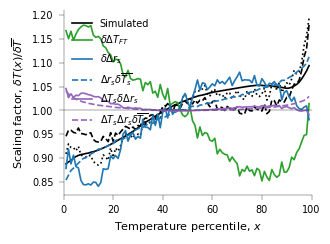

In [124]:
linestyles_breakdown = {'t_mean_change': '--', 'r_mean_change': '-.', 'e_mean_change': ':', 
                        'anomaly_change': '-'}
colors_breakdown2 = {'t0': default_colors[3], 'r0': default_colors[0], 't0_r0': default_colors[4], 'e0': default_colors[1], 
                     'e': default_colors[1], 'r': default_colors[0], 't0_r': default_colors[4], 
                     'ft': default_colors[2]}
labels_breakdown2 = {'t0': '$\Delta T_s$', 'r0': '$\Delta r_s$', 't0_r0': '$\Delta T_s \Delta r_s$', 'e0': '$\Delta \epsilon$', 
                     'e': '$\delta \Delta \epsilon$', 'r': '$\delta \Delta r_s$', 't0_r': '$\Delta T_s\delta \Delta r_s$', 
                     'ft': '$\delta \Delta T_{FT}$'}

save_sig_terms_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k',
           label='Simulated')
ax.plot(quant_plot, np.average(sf_theory['linear'], weights=lat_weights, axis=0), color='k', linestyle='--')
ax.plot(quant_plot, np.average(sf_theory['non_linear'], weights=lat_weights, axis=0), color='k', linestyle=':')
for i in range(n_sig_terms):
    key1 = info_sig_terms['key1'][i]
    key2 = info_sig_terms['key2'][i]
    ax.plot(quant_plot, 1+np.average(sf_theory_breakdown[key1][key2], weights=lat_weights, axis=0), color=colors_breakdown2[key2],
            linestyle=linestyles_breakdown[key1], label=labels_breakdown2[key2] + ('' if 'anomaly' in key1 else labels_breakdown1[key1]))
ax.legend()
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)

if save_fig or save_sig_terms_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_sig_terms_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

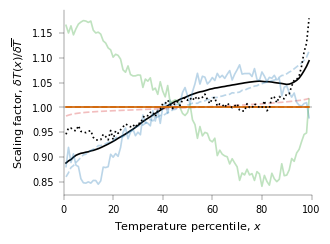

In [46]:
save_custom_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))

# Start with strict convective equilibrium theory
ax.plot(quant_plot, np.average(sf_simulated, weights=lat_weights, axis=0), color='k',
           label='Simulated')
# ax.plot(quant_plot, np.average(sf_theory['no_epsilon'], weights=lat_weights, axis=0), color='k', linestyle=':')
for i, key in enumerate([['t_mean_change', 't0'], ['t_mean_change', 'r0'], ['anomaly_change', 'r'], ['anomaly_change', 'ft']]):
    if i > 3:
        continue
    ax.plot(quant_plot, 1+np.average(sf_theory_breakdown[key[0]][key[1]], weights=lat_weights, axis=0), color=colors_breakdown2[key[1]],
            linestyle=linestyles_breakdown[key[0]], 
            label=labels_breakdown2[key[1]] + ('' if 'anomaly' in key[0] else labels_breakdown1[key[0]]), alpha=0.3)

# #Add epsilon deviation
for i, key in enumerate([['t_mean_change', 'e0'], ['anomaly_change', 'e']]):
    if i>1:
        continue
    ax.plot(quant_plot, 1+np.average(sf_theory_breakdown[key[0]][key[1]], weights=lat_weights, axis=0), color=colors_breakdown2[key[1]],
            linestyle=linestyles_breakdown[key[0]], label=labels_breakdown2[key[1]] + ('' if 'anomaly' in key[0] else labels_breakdown1[key[0]]))
ax.plot(quant_plot, np.average(sf_theory['non_linear'], weights=lat_weights, axis=0), color='k', linestyle=':')

ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
# if is_land_data:
#     ax.set_ylim(0.8, 1.2)
# else:
#     ax.set_ylim(0.93, 1.18)


if save_fig or save_custom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_custom_terms_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)